# COMBINE STATS

In [1]:
# Imports

import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Presets

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

/Users/zacharymeurer/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# College Stats

### Information on Advanced Stats

Note: twoPM (2 Pointers Made) vs. TPM (3 Pointers Made) | Idk what porpag's formula is | Idk what pfr is or its formula | Idk why recrank (Recruit Rankings) is a float from [0,100] | Drtg is super complicated formula for no reason | 

Ortg (Offensive Production Rating) = $\frac{Points Produced}{Individual Possessions} × OAPOW × PPG + \frac{FTM}{FT} * 3pt\% + FG\%$

usg (Usage Rate) = $\frac{Possessions\ Ended\ by\ Player}{Total\ Team\ Possessions\ with\ Player\ on\ Court} × 100\%$

eFG% (Effective Field Goal Percentage) = $\frac{FG + 0.5 * 3P}{FGA}$

TS% (True Shooting Percentage) = $\frac{PTS}{2(FGA + 0.44 * FTA)}$

TO% (Turnover Percentage) = $\frac{TO*100}{FGA+FTA*0.44+AST+TO}$

BLK% (Block Percentage) = $ \frac{100 * BLK * \frac{Tm\ MP}{5}}{MP(Opp\ FGA - Opp\ 3PA)}$ Tm = Team, MP = Minutes Played

ftr (Free Throw Rate) = $ \frac{FTA}{FGA}$

adjoe (Adjusted Offensive Efficiency) = Points per 100 possessions adjusted for opponent

Drtg (Defensive Rating) = $Team\ Defensive\ Rating + 0.2 (100 * D\ Pts\ per\ ScPoss (1 - Stop\%) - Team\ Defensive\ Rating)$ https://www.basketball-reference.com/about/ratings.html

bpm (Box Plus Minus) = a box score estimate of the points per 100 possessions that a player contributed above a league-average player

RPI (Rating Percentage Index) = Ratings for each conference based on their W/L records. https://www.teamrankings.com/ncaa-basketball/rpi-ranking/rpi-rating-by-conf

In [2]:
# Functions

def hists_from_list(df,fields):
    for stat in fields:
        df[stat].plot(kind='hist', x=stat, title=stat+' histogram')
        plt.show()
        print(f"min: {df[stat].min()}, max: {df[stat].max()}, mean: {df[stat].mean()}, median: {df[stat].median()}, stdev: {df[stat].std()}")

def w_avg(df, values, weights): # Code from https://www.statology.org/pandas-weighted-average/
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

def scat_polyfit(df,stat1,stat2):
    x = df[stat1]
    y = df[stat2]

    y_predicted = [np.poly1d(np.polyfit(x, y, 10))(i) for i in x]
    
    plt.xlabel(stat1)
    plt.ylabel(stat2)
    plt.scatter(x,y,label='f(x)')
    plt.scatter(x,y_predicted,label='fitted regression')
    plt.legend()
    plt.show()
    
def get_tr_url(year, group):
    if group == 'conference':
        return f"https://www.teamrankings.com/ncaa-basketball/rpi-ranking/rpi-rating-by-conf?date={year}-04-04"
    elif group == 'team':
        return f"https://www.teamrankings.com/ncaa-basketball/ranking/predictive-by-other/?date={year}-04-04"

def create_strength_dict(ncaa_df, replace_dict, year, group):
    if group == 'conference':
        conf_df = pd.read_html(get_tr_url(year, group))[0]
        conf_df = conf_df.replace('--',np.nan)
        conf_df = conf_df.replace({'Conference': replace_dict})
        conf_dict = dict(zip(conf_df["Conference"],conf_df["Rating"].astype("float")))
        return ncaa_df[ncaa_df["year"]==year].replace({"conf": conf_dict})["conf"].to_dict()
    elif group == 'team':
        team_df = pd.read_html(get_tr_url(year, group))[0]
        team_df["Team"] = list(map(lambda x: re.sub("\s\(.+","",x), team_df["Team"]))
        team_df = team_df.replace({'Team': replace_dict})
        team_dict = dict(zip(team_df["Team"], team_df["Rating"].astype("float")))
        return ncaa_df[ncaa_df["year"]==year].replace({"team": team_dict})["team"].to_dict()

In [3]:
# Prepping data for machine learning

ncaa_df = pd.read_csv("CollegeBasketballPlayers2009-2021.csv", low_memory=False).dropna(subset=["pick"])

# Cleaning ncaa_df
ncaa_df = ncaa_df.rename(columns={"Unnamed: 64": "position"})
ncaa_df = ncaa_df.drop("Unnamed: 65",axis=1)

# Prepping ncaa_df to work with the conference RPI data about to be scraped from teamrankings.com
ncaa_df["team"] = list(map(lambda x: re.sub("[.']", "", x), ncaa_df["team"]))
ncaa_df["conf"] = ncaa_df["conf"].replace('P10','P12')
ncaa_df[ncaa_df["player_name"] == 'Stephen Curry'] = ncaa_df[ncaa_df["player_name"] == 'Stephen Curry'].replace('SC','A10')
ncaa_df[ncaa_df["player_name"] == 'Andrew Goudelock'] = ncaa_df[ncaa_df["player_name"] == 'Andrew Goudelock'].replace('SC','CAA')

# Data scraping teamrankings.com for conference RPIs and creating a new field with them
conf_replace_dict = {'Atlantic 10': 'A10',
                     'Big 12': 'B12', 
                     'Big Ten': 'B10', 
                     'Mountain West': 'MWC', 
                     'Big East': 'BE', 
                     'Pac-12': 'P12', 
                     'American': 'Amer',
                     'Sun Belt': 'SB',
                     'Big West': 'BW',
                     'Summit': 'Sum',
                     'Big Sky': 'BSky',
                     'Horizon League': 'Horz',
                     'Patriot': 'Pat',
                     'Ohio Valley': 'OVC'}

team_replace_dict = {'Boston College': 'Boston Col',
                     'Bowling Green': 'Bowling Grn',
                     'College of Charleston': 'Col Charlestn',
                     'East Carolina': 'E Carolina',
                     'Eastern Washington': 'E Washingtn',
                     'Georgia Tech': 'GA Tech',
                     'Green Bay': 'WI-Grn Bay',
                     'Long Beach St': 'Lg Beach St',
                     'Louisiana Lafayette': 'Lafayette',
                     'Louisiana Tech': 'LA Tech',
                     'Loyola MD': 'Loyola-MD',
                     'Massachusetts': 'U Mass',
                     'Miami FL': 'Miami',
                     'Mississippi St': 'Miss State',
                     'New Mexico St': 'N Mex State',
                     'North Carolina': 'N Carolina',
                     'North Carolina St': 'NC State',
                     'Northern Illinois': 'N Illinois',
                     'SMU': 'S Methodist',
                     'Saint Josephs': 'St Josephs',
                     'Saint Marys': 'St Marys',
                     'South Carolina': 'S Carolina',
                     'South Dakota St': 'S Dakota St',
                     'South Florida': 'S Florida',
                     'St Bonaventure': 'St Bonavent',
                     'TCU': 'TX Christian',
                     'Tennessee Martin': 'TN Martin',
                     'Tennessee Tech': 'TN Tech',
                     'UC Santa Barbara': 'UCSB',
                     'UT Arlington': 'TX-Arlington',
                     'UTEP': 'TX El Paso',
                     'Virginia Tech': 'VA Tech',
                     'Washington St': 'Wash State',
                     'West Virginia': 'W Virginia',
                     'Western Kentucky': 'W Kentucky',
                     'William & Mary': 'Wm & Mary'}

conf_strength_dict = {}
team_strength_dict = {}
years = ncaa_df["year"].sort_values().unique()
for year in years:
    conf_strength_dict = conf_strength_dict | create_strength_dict(ncaa_df, conf_replace_dict, year, 'conference')
    team_strength_dict = team_strength_dict | create_strength_dict(ncaa_df, team_replace_dict, year, 'team')
ncaa_df.insert(2, "team_str", conf_strength_dict.values())
ncaa_df.insert(4, "conf_str", conf_strength_dict.values())



# Making a new dataframe to contain the weighted averages
weighting_df = ncaa_df.copy()
weighting_df = weighting_df[weighting_df["pid"].duplicated()==False]
weighting_df = weighting_df.set_index("pid")

# Group by with weighted Average (Code from https://www.statology.org/pandas-weighted-average/)
unwanted_stats = ["player_name","team","team_str","conf","conf_str","GP","Min_per","yr","ht","num","year","pid","type","pick","mp","position"]
wanted_stats = [ele for ele in ncaa_df.columns if ele not in unwanted_stats]
for stat in wanted_stats:
    weighting_df[stat] = ncaa_df.groupby("pid").apply(w_avg, stat, "Min_per")

# Normalizing
from sklearn.preprocessing import MinMaxScaler
weighted_df = weighting_df.copy()

# Define stats that should be normalized
unwanted_stats = ["player_name","team","conf","yr","ht","num","year","pid","type","pick","position"]
wanted_stats = [ele for ele in ncaa_df.columns if ele not in unwanted_stats]

# Apply normalization techniques
for stat in wanted_stats:
    weighted_df[stat] = MinMaxScaler().fit_transform(np.array(weighted_df[stat]).reshape(-1,1))

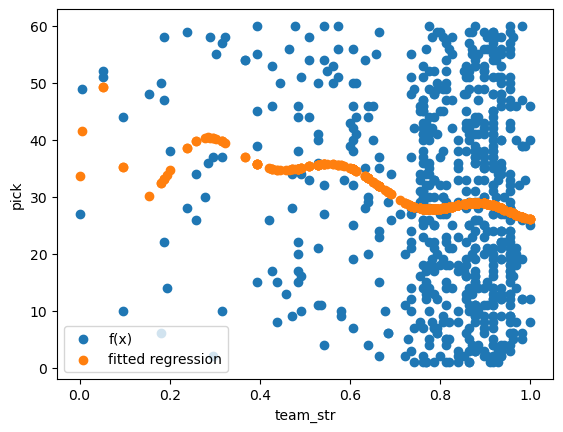

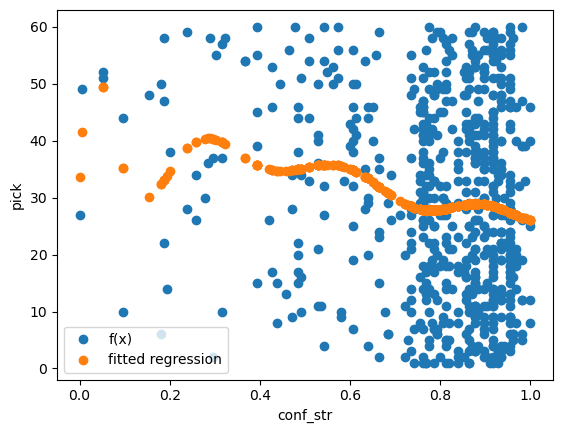

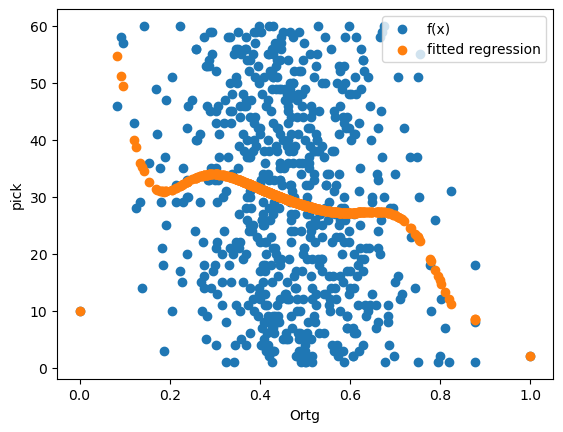

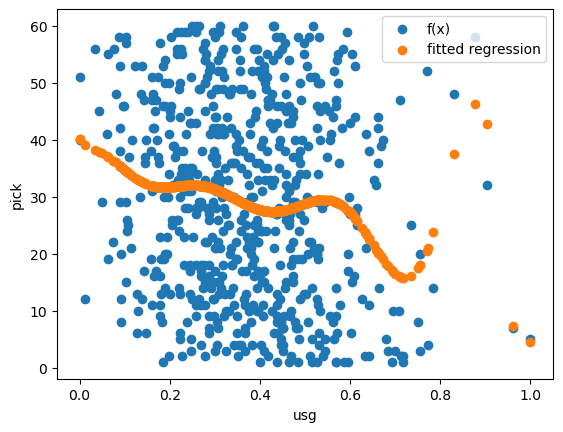

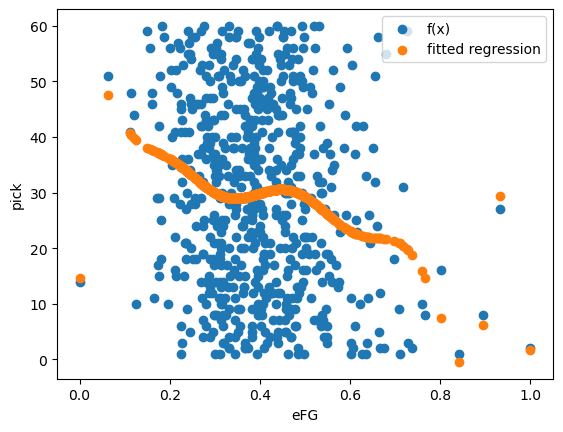

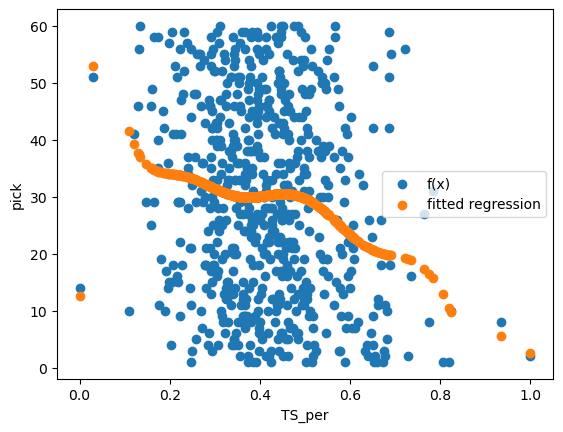

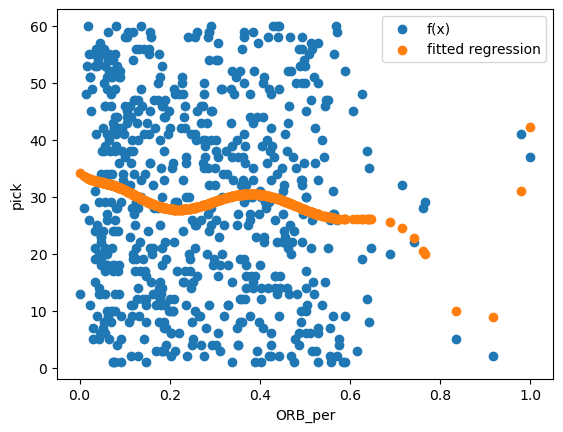

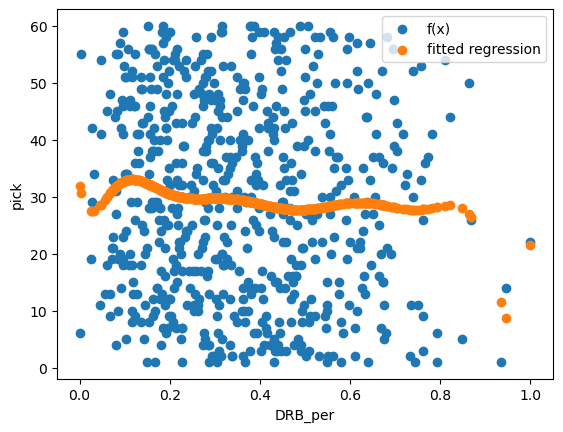

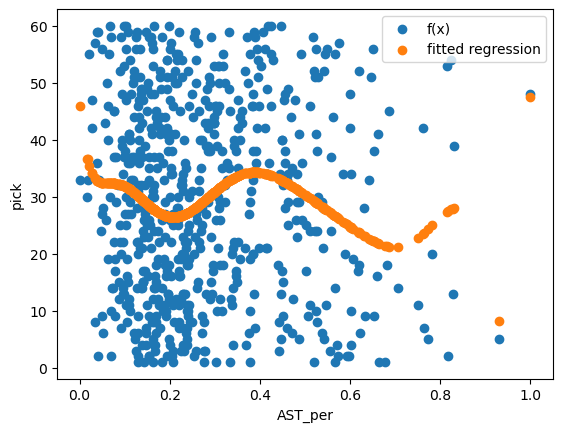

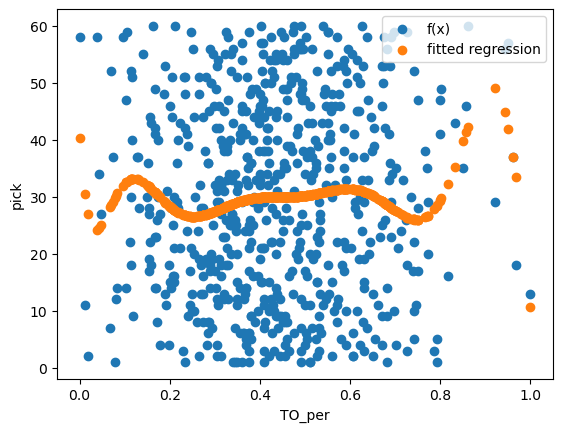

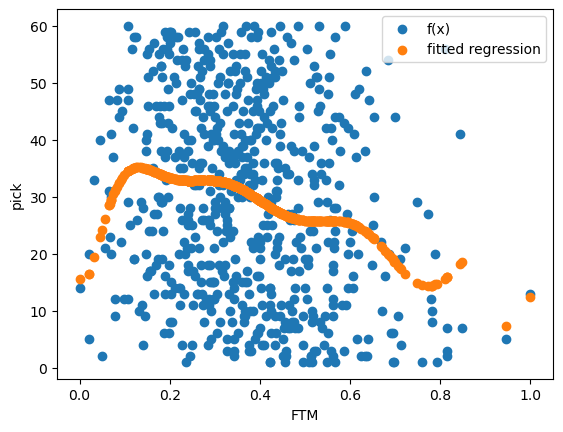

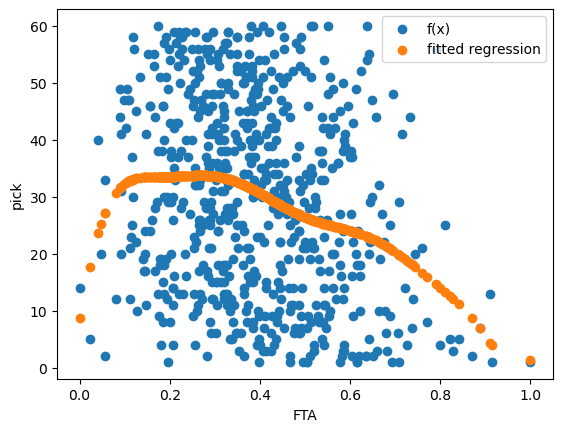

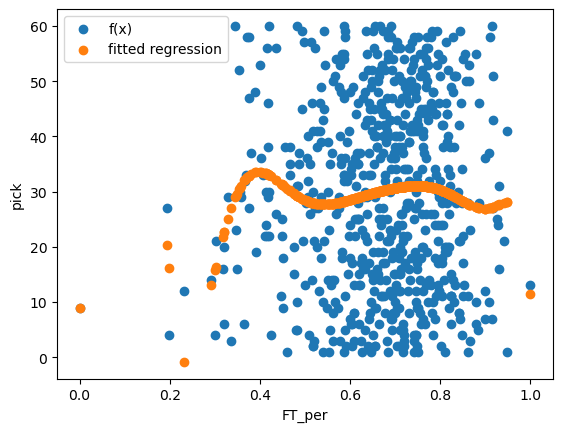

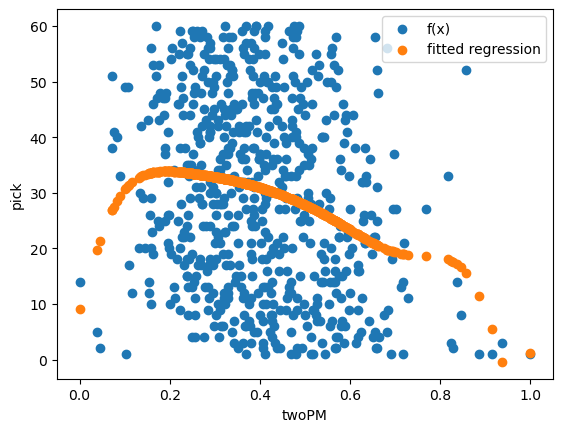

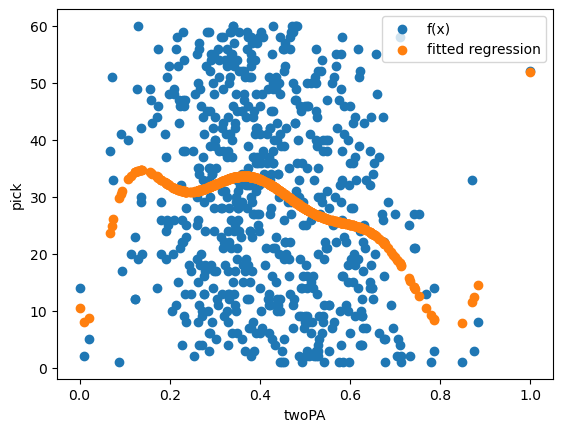

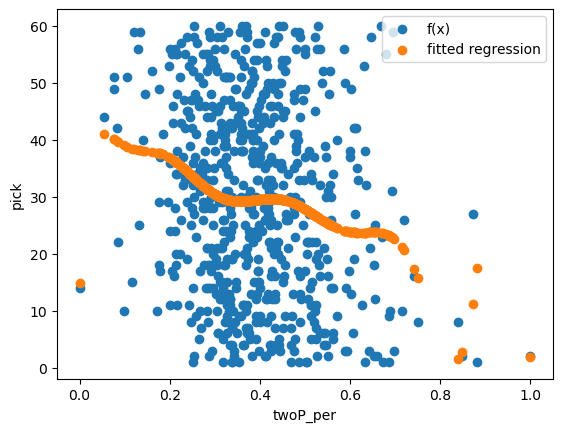

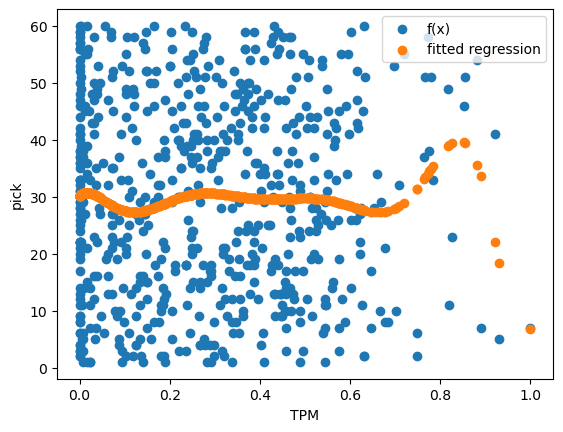

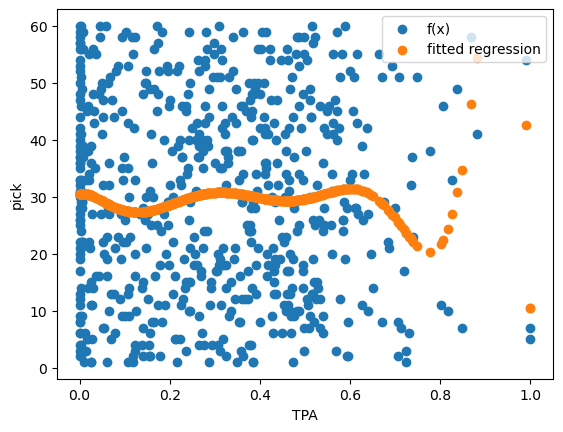

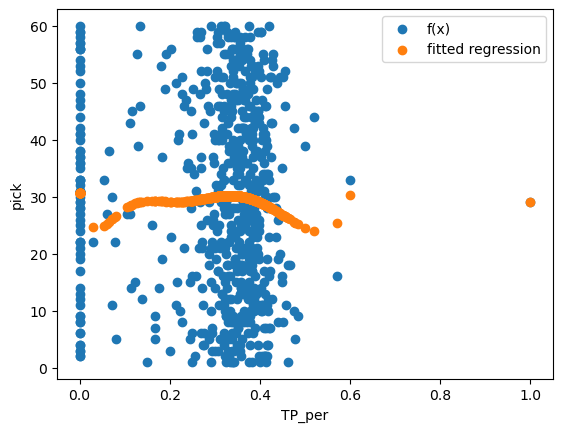

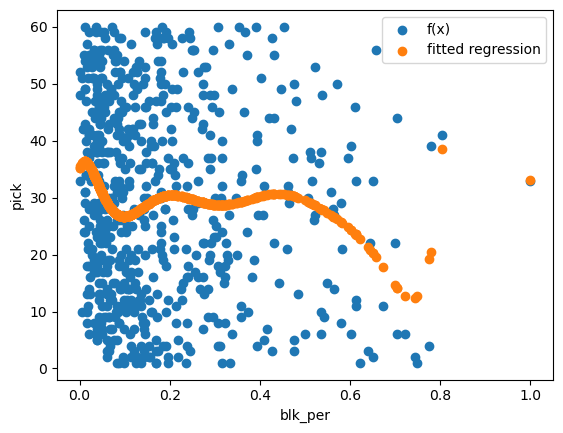

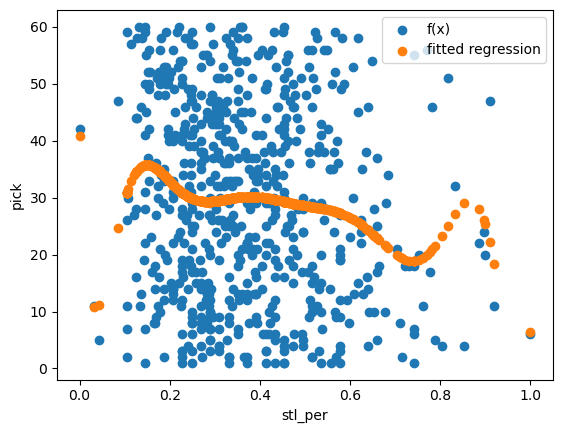

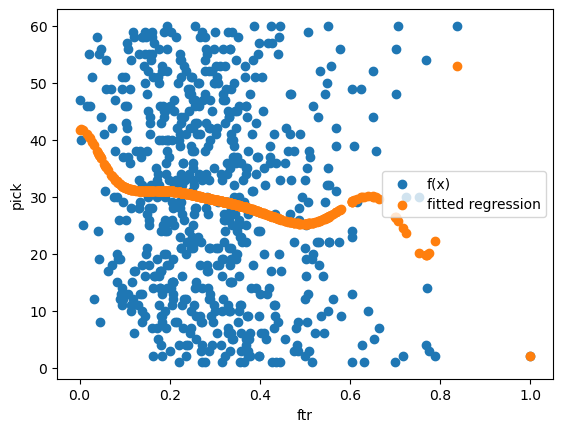

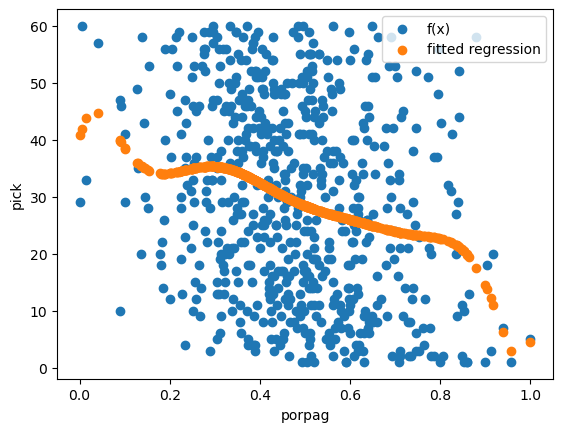

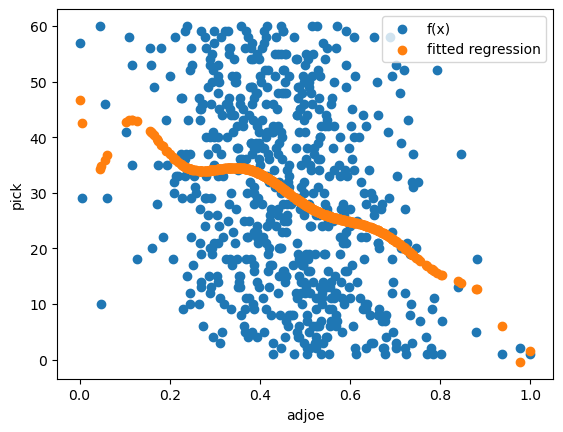

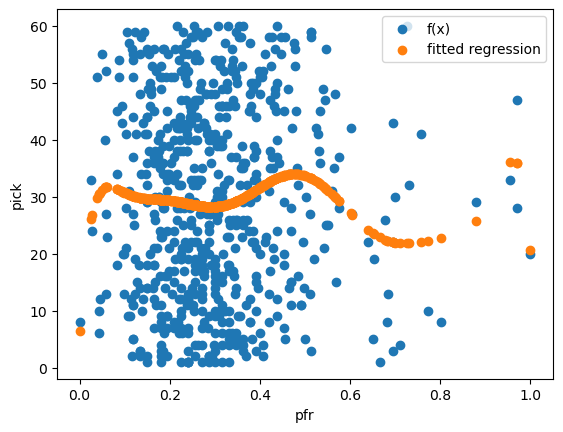

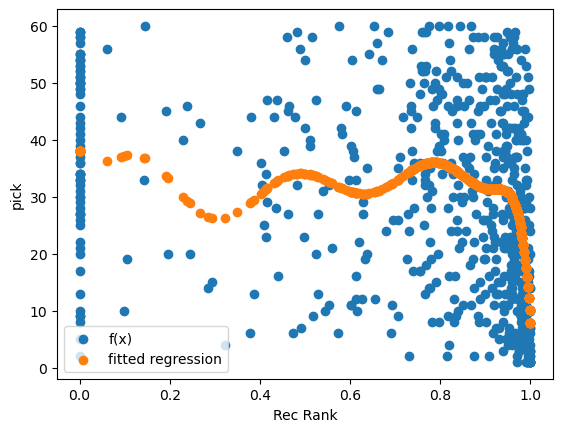

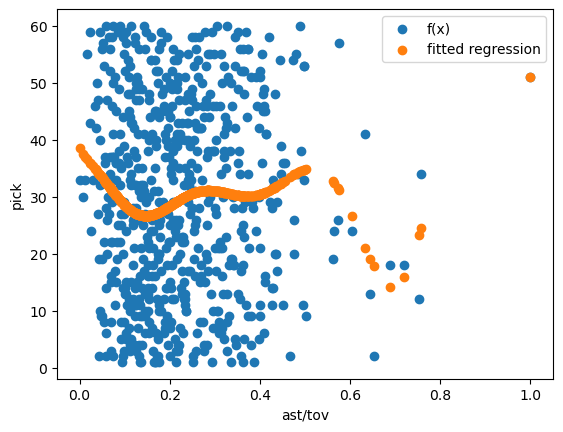

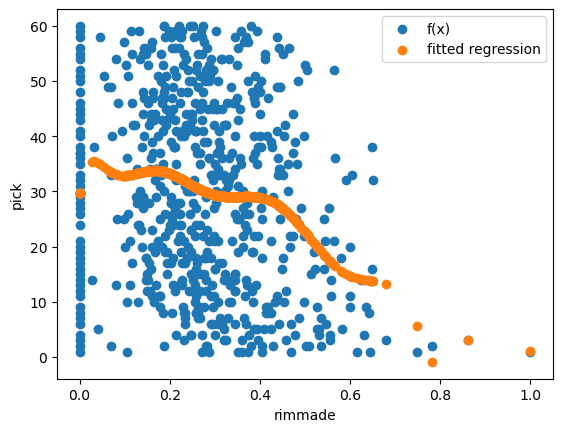

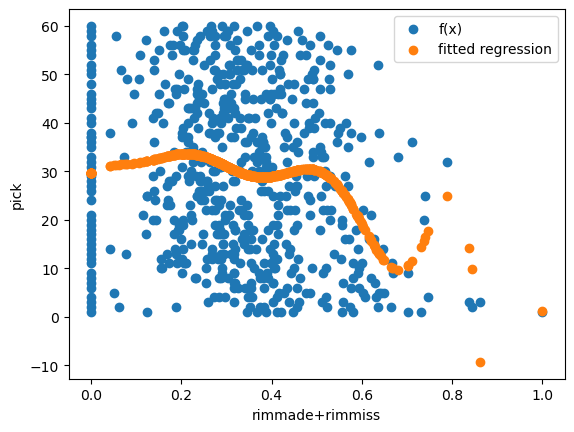

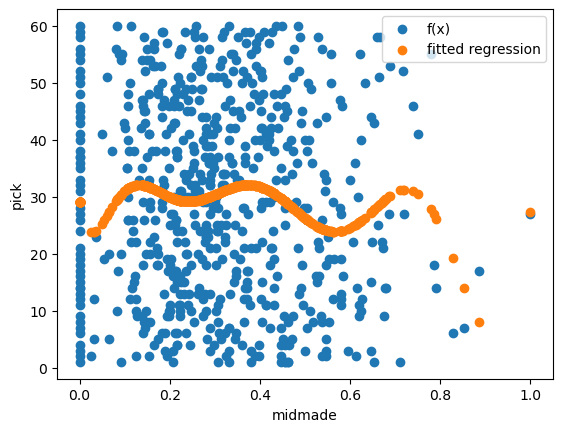

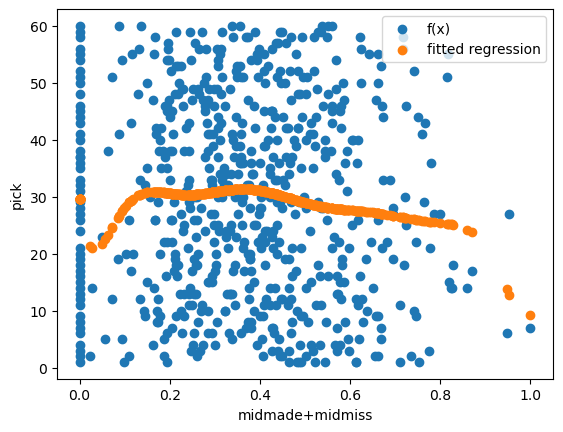

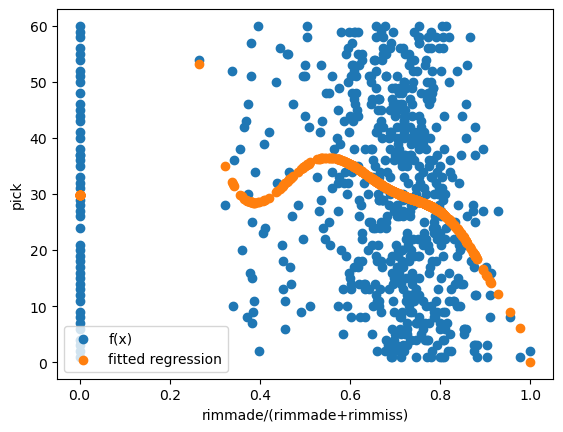

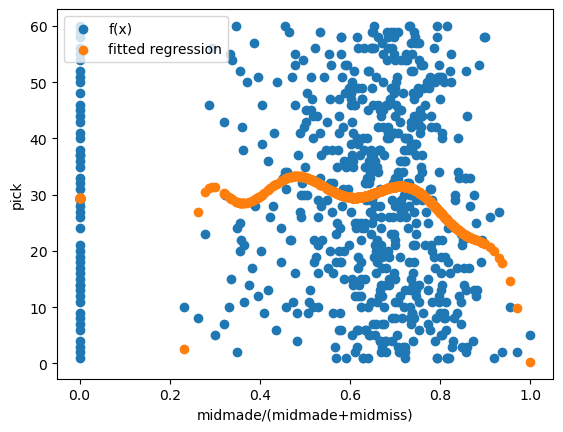

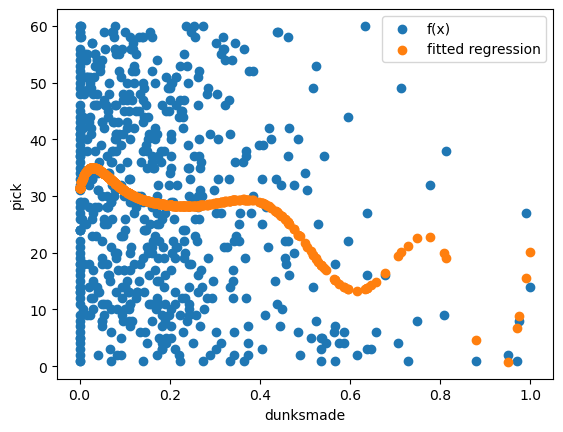

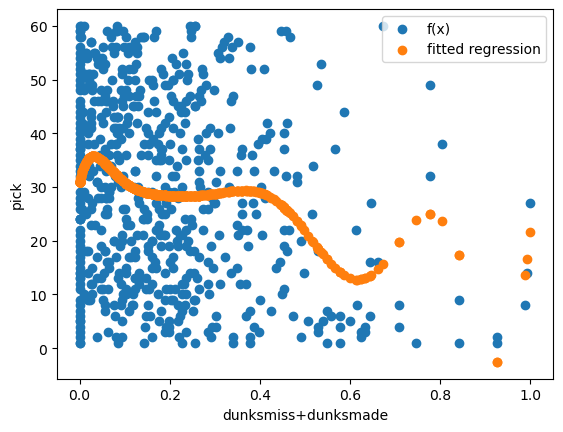

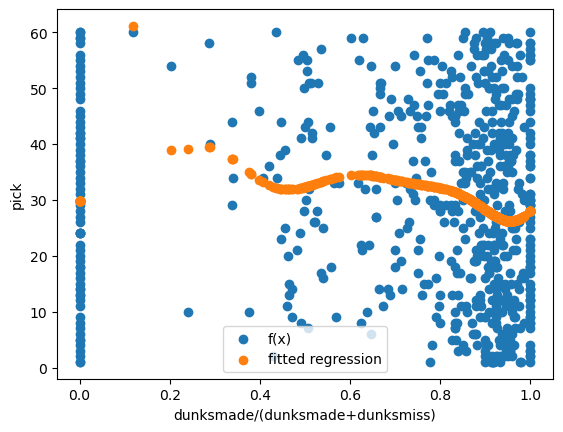

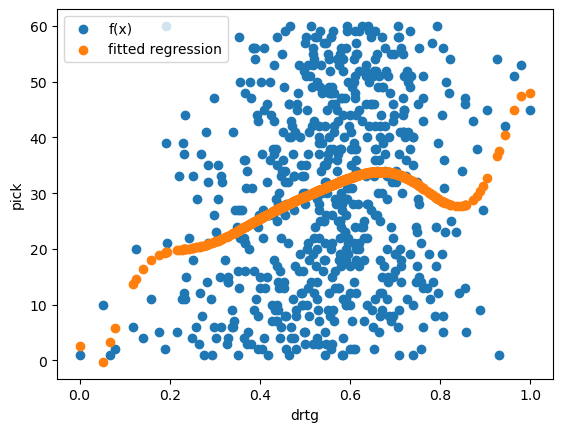

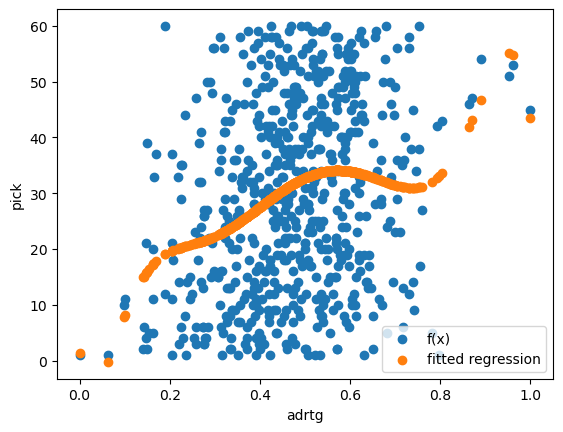

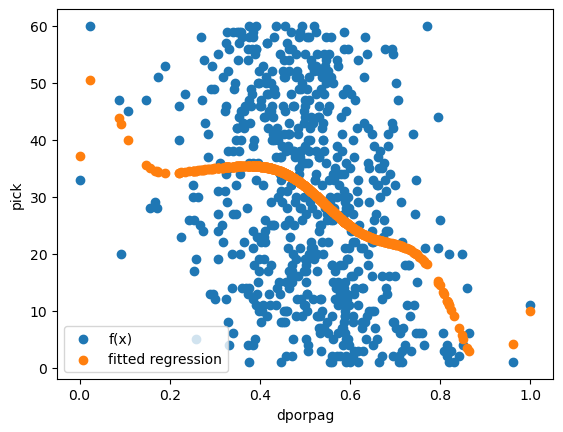

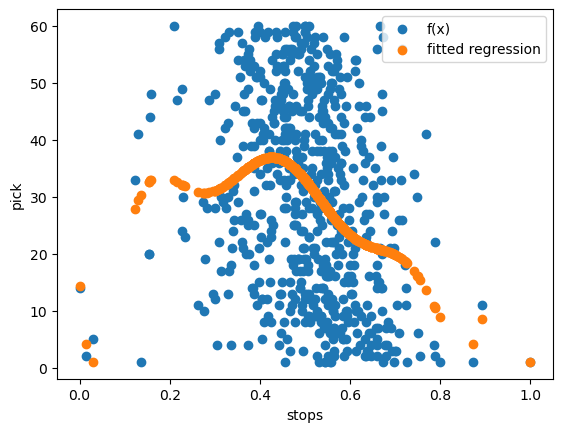

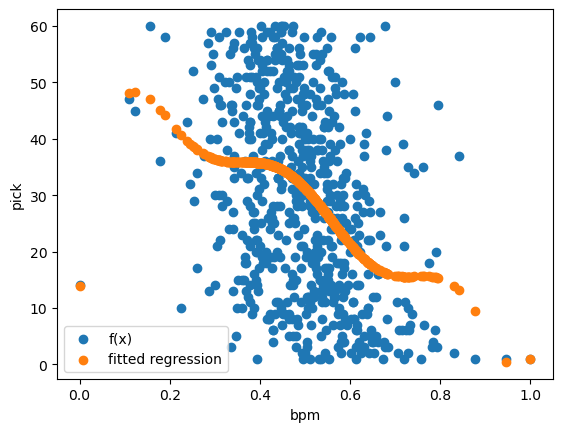

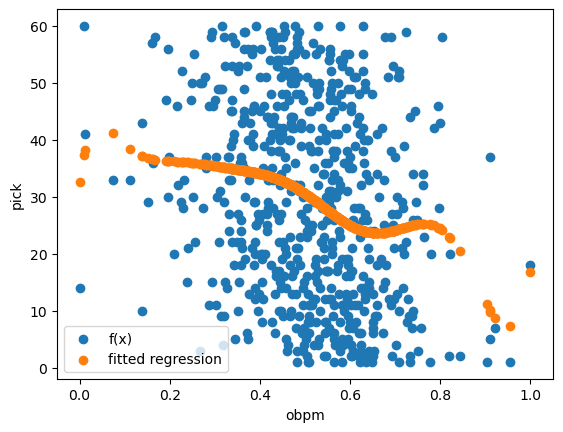

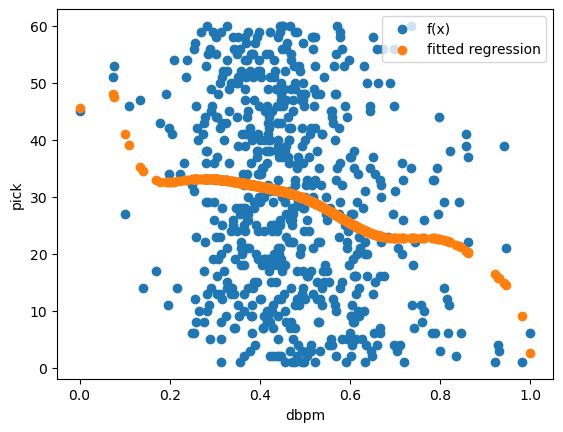

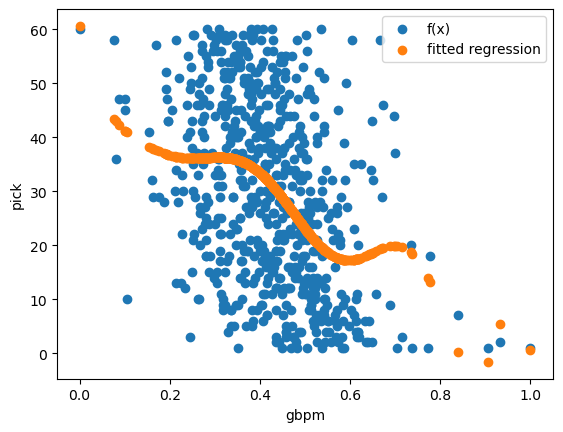

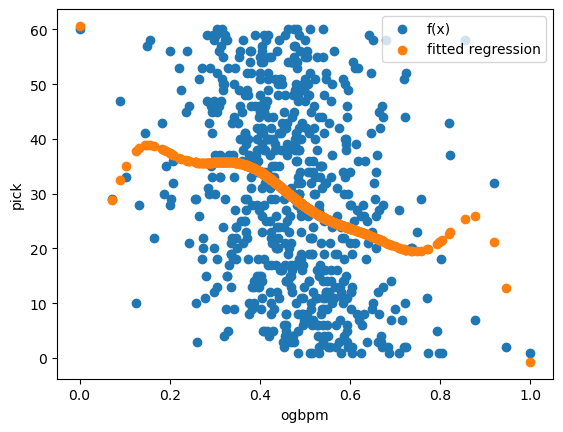

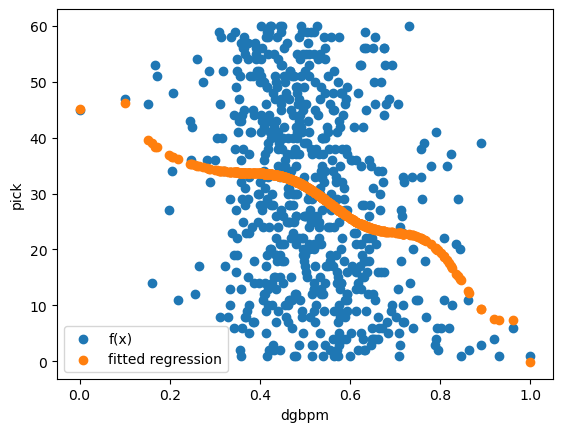

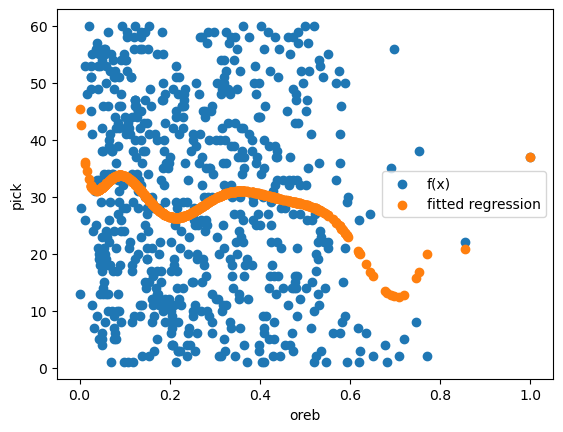

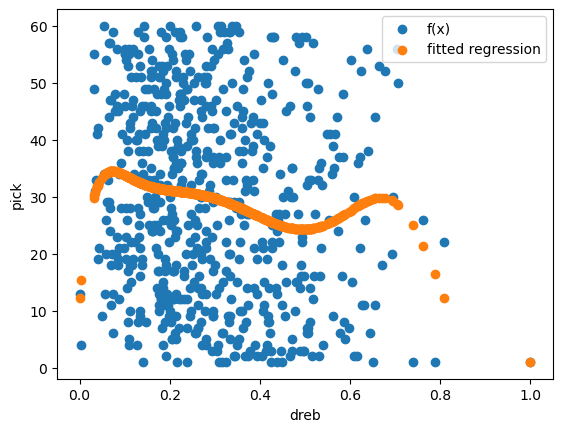

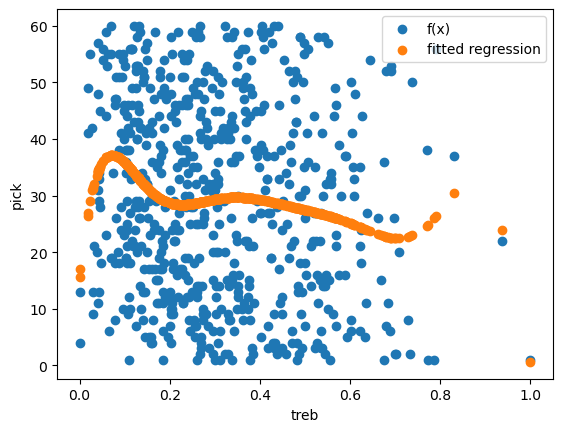

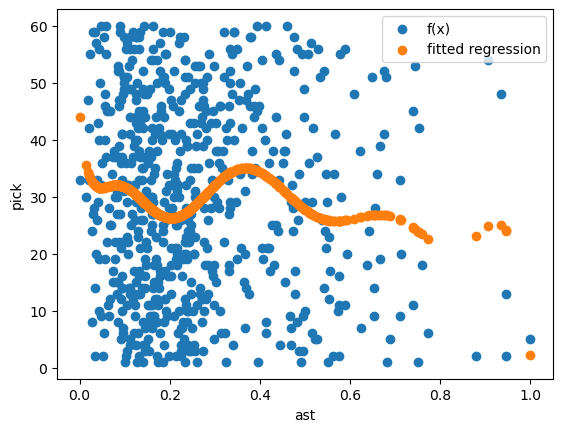

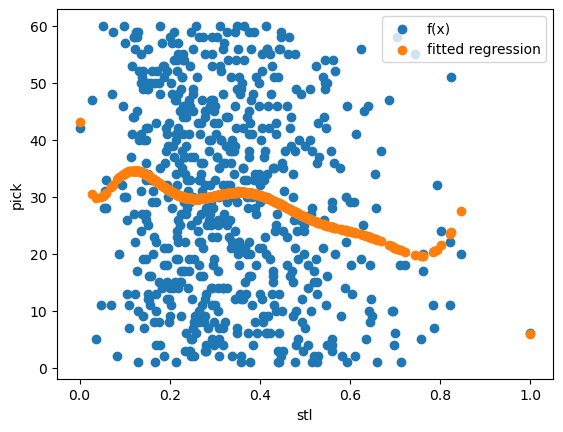

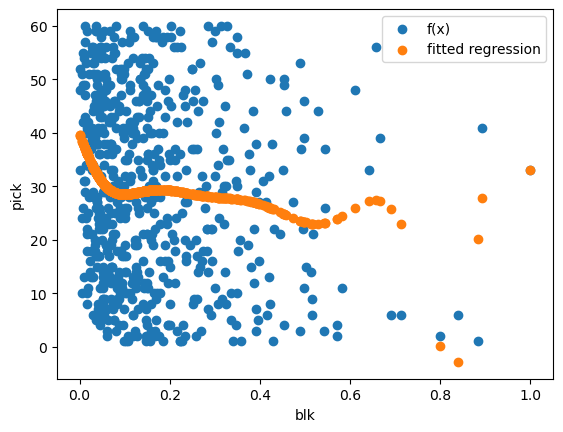

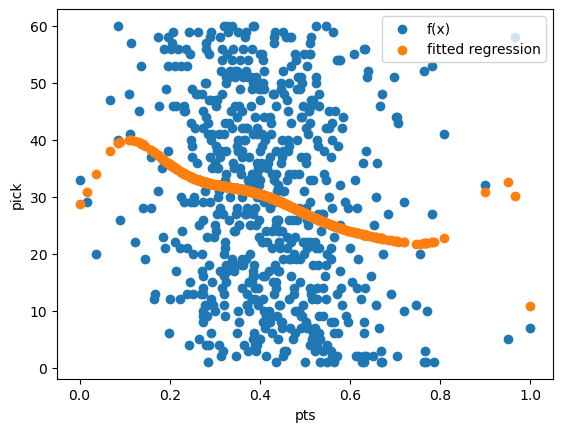

In [4]:
# Logistic Regression Scatterplot over all relevant statistics

unwanted_stats = ["player_name","team","conf","GP","Min_per","yr","ht","num","year","pid","type","pick","mp","position"]
wanted_stats = [ele for ele in weighted_df.columns if ele not in unwanted_stats]
for stat in wanted_stats:
    scat_polyfit(weighted_df,stat,"pick")

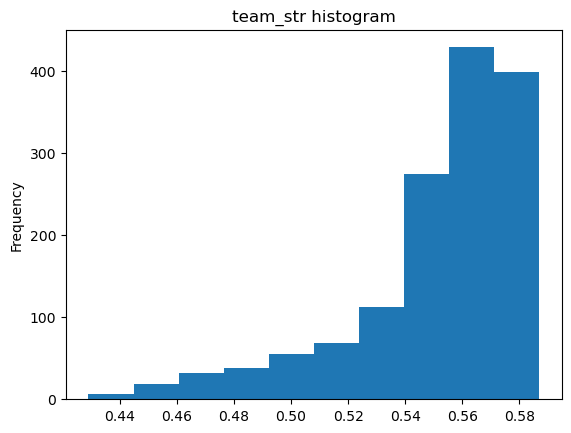

min: 0.429, max: 0.587, mean: 0.5517372822299651, median: 0.559, stdev: 0.030235476998338864


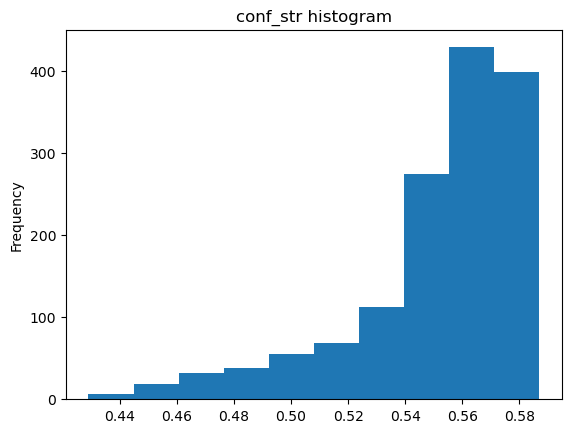

min: 0.429, max: 0.587, mean: 0.5517372822299651, median: 0.559, stdev: 0.030235476998338864


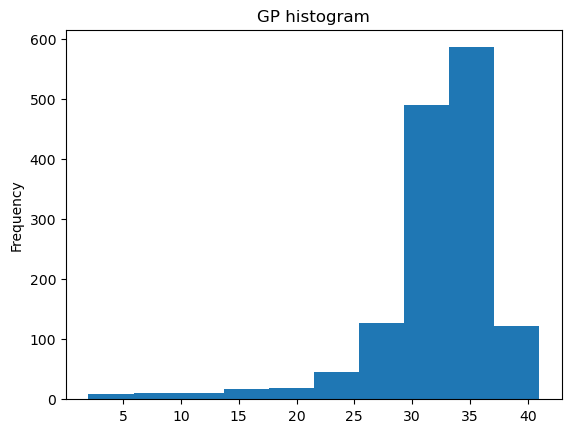

min: 2, max: 41, mean: 32.3205574912892, median: 33.0, stdev: 5.488833825150504


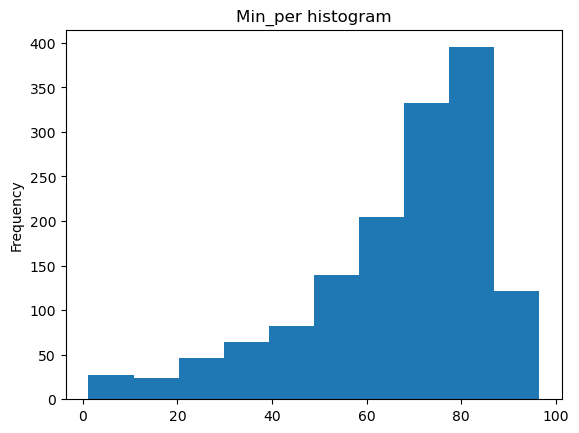

min: 1.2, max: 96.5, mean: 66.495818815331, median: 72.2, stdev: 19.577828715300463


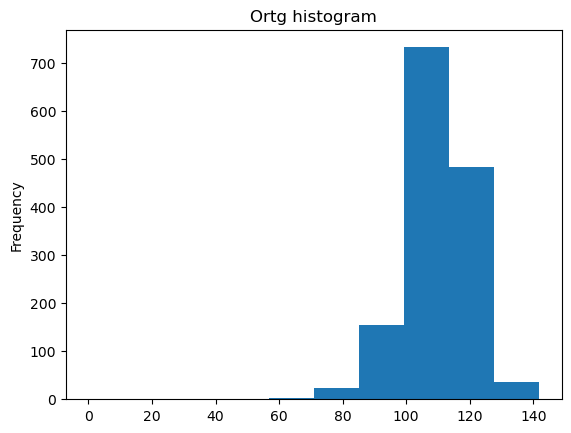

min: 0.0, max: 141.9, mean: 109.99526132404182, median: 110.4, stdev: 10.27847026701874


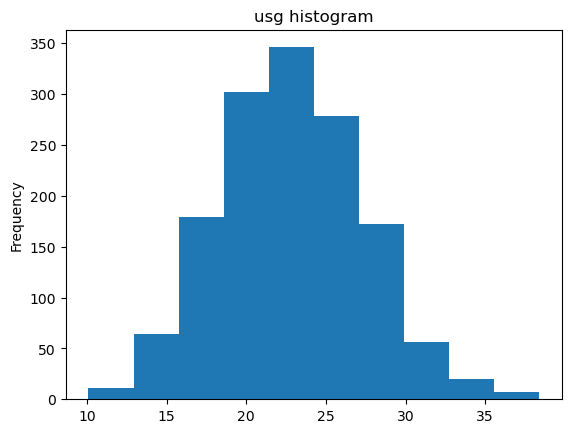

min: 10.1, max: 38.4, mean: 22.823135888501742, median: 22.6, stdev: 4.492809371092916


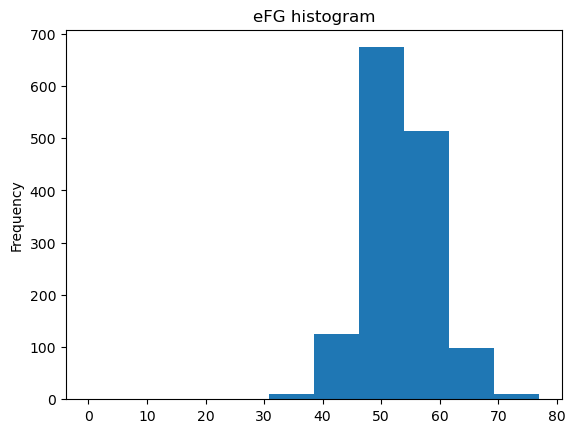

min: 0.0, max: 77.0, mean: 53.082926829268295, median: 52.9, stdev: 6.057113785538484


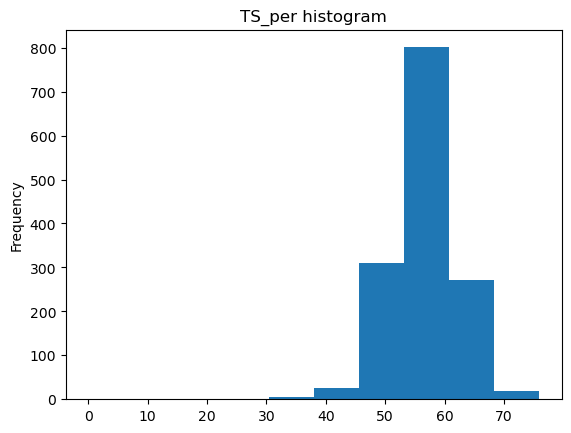

min: 0.0, max: 75.98, mean: 56.52473170731707, median: 56.64, stdev: 5.508671595019653


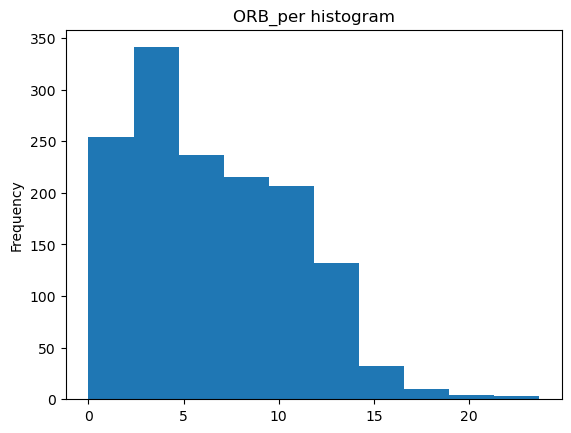

min: 0.0, max: 23.7, mean: 6.608919860627177, median: 5.9, stdev: 4.123106118281569


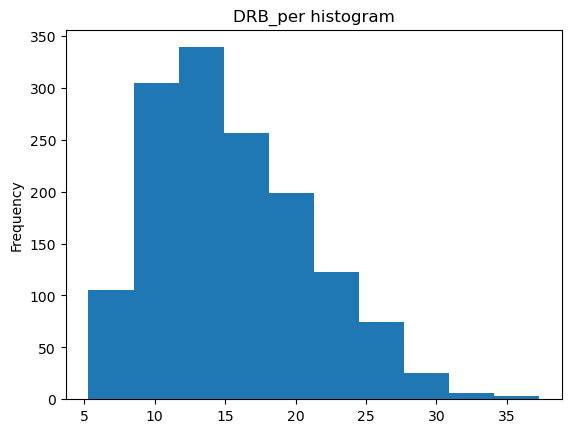

min: 5.3, max: 37.3, mean: 15.473170731707317, median: 14.5, stdev: 5.4912036335677215


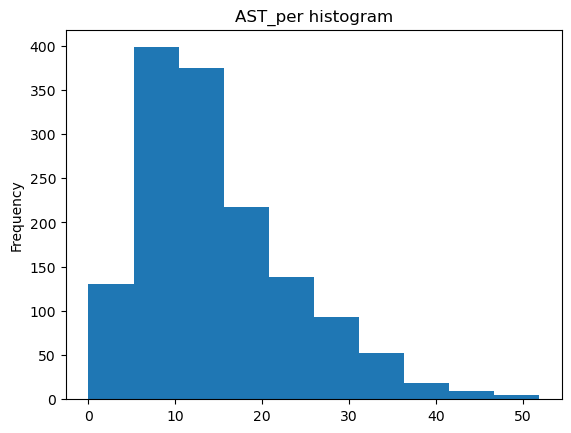

min: 0.0, max: 51.9, mean: 14.758118466898956, median: 12.6, stdev: 8.899058642013149


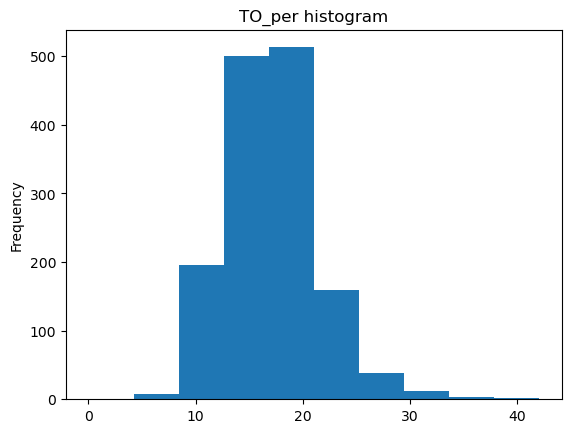

min: 0.0, max: 42.1, mean: 17.16885017421603, median: 16.9, stdev: 4.373637074240838


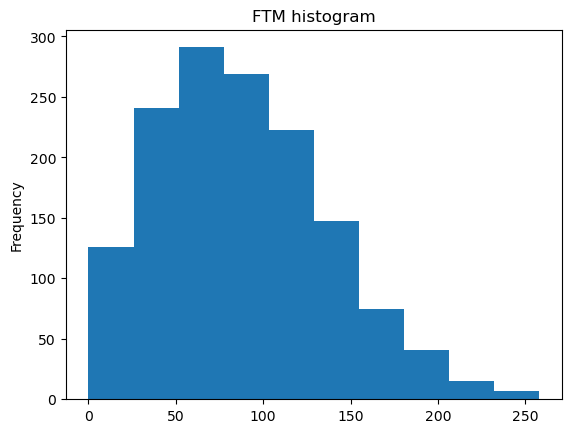

min: 0, max: 258, mean: 87.69407665505227, median: 84.0, stdev: 48.21438279460488


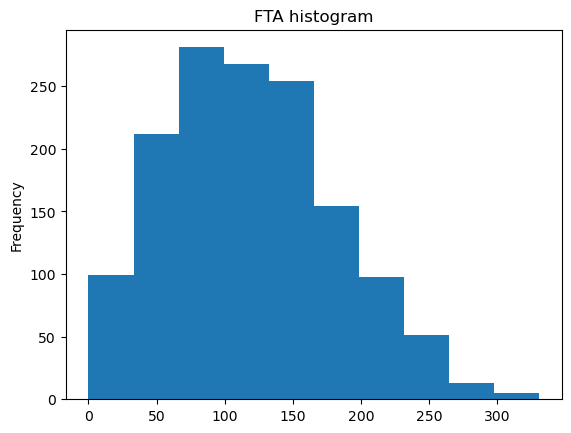

min: 0, max: 331, mean: 119.44250871080139, median: 114.0, stdev: 61.48807873350707


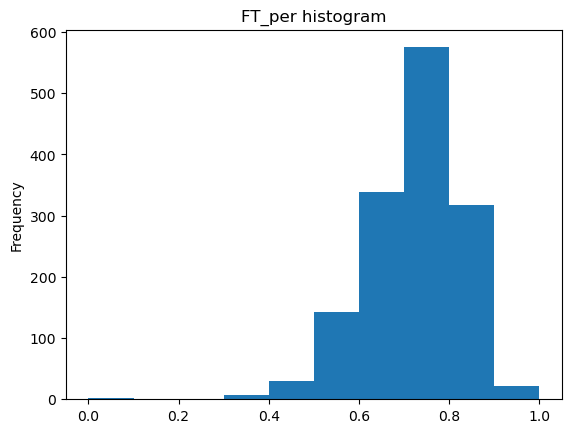

min: 0.0, max: 1.0, mean: 0.7225937282229965, median: 0.737, stdev: 0.10542115888980473


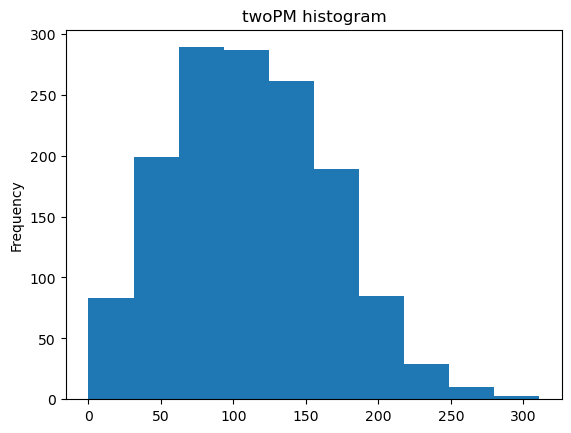

min: 0, max: 311, mean: 111.68432055749129, median: 109.0, stdev: 53.9660386853575


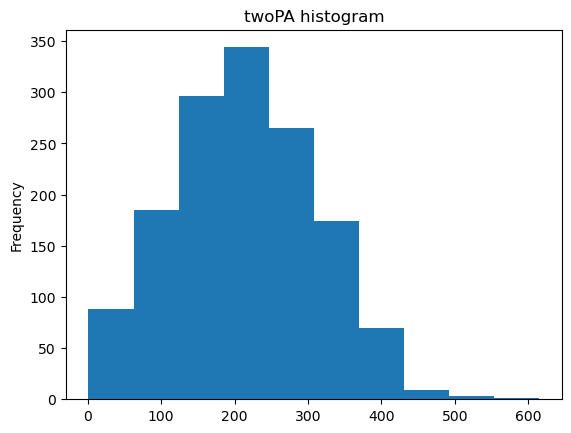

min: 1, max: 615, mean: 213.18745644599304, median: 211.0, stdev: 97.18448062068275


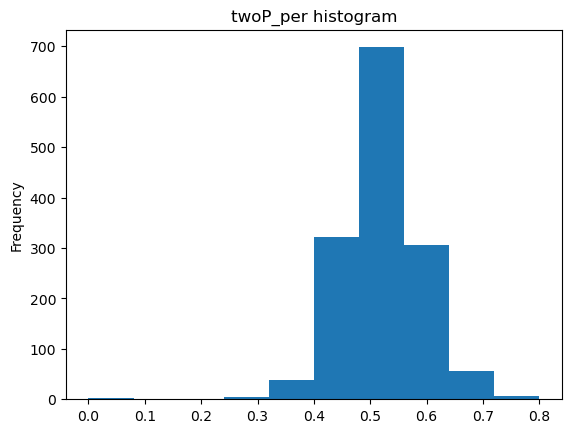

min: 0.0, max: 0.8, mean: 0.5201038327526132, median: 0.517, stdev: 0.0702026133696813


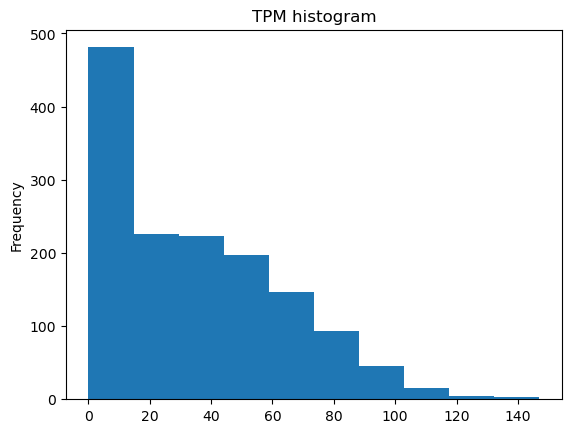

min: 0, max: 147, mean: 34.26202090592334, median: 30.0, stdev: 29.3445776930869


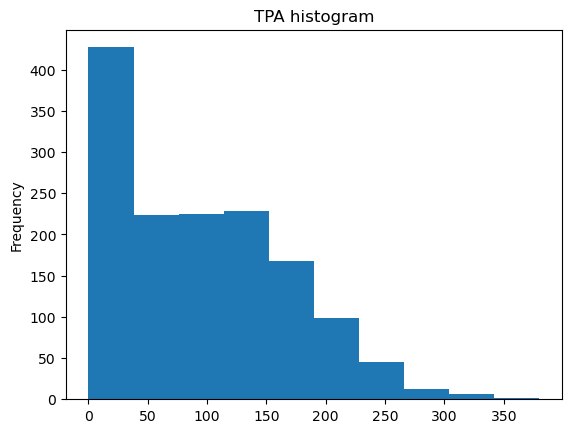

min: 0, max: 380, mean: 93.32822299651568, median: 87.0, stdev: 74.05656931114979


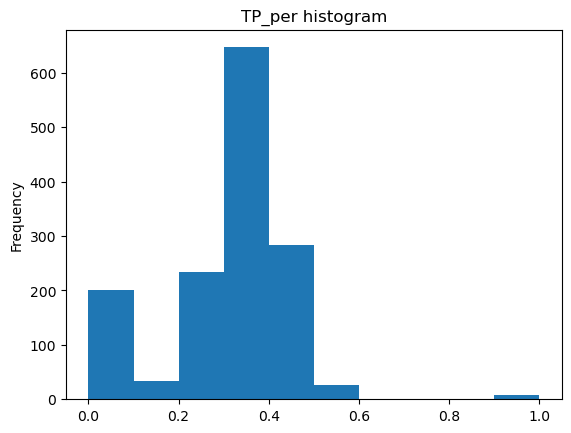

min: 0.0, max: 1.0, mean: 0.30656724738675956, median: 0.346, stdev: 0.148746829978357


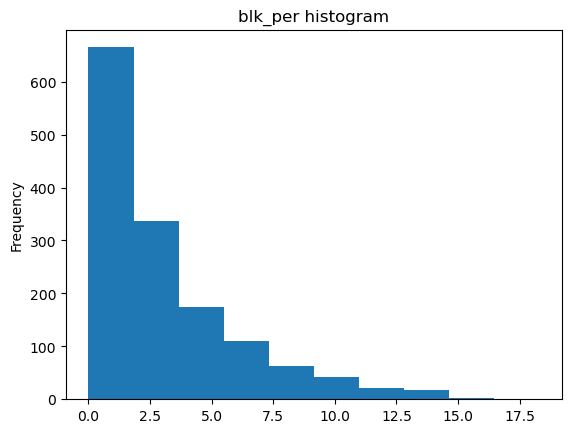

min: 0.0, max: 18.3, mean: 3.126411149825784, median: 2.0, stdev: 3.00022419169526


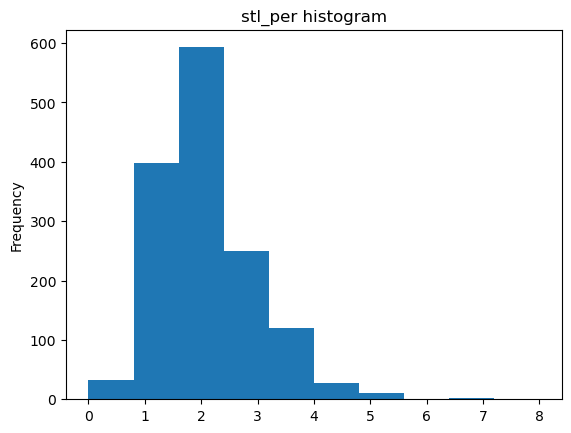

min: 0.0, max: 8.0, mean: 2.076724738675958, median: 1.9, stdev: 0.8870927105872136


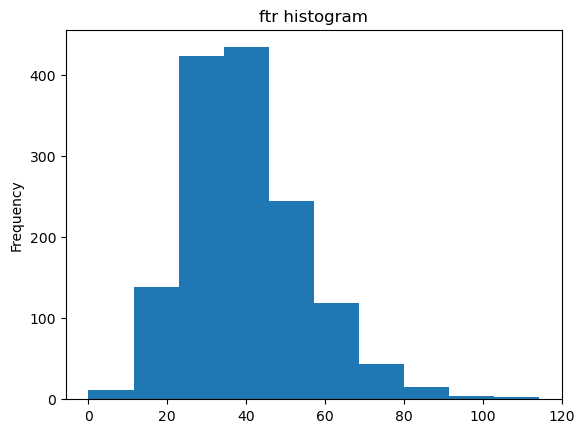

min: 0.0, max: 114.3, mean: 39.7993031358885, median: 38.1, stdev: 15.126319791033008


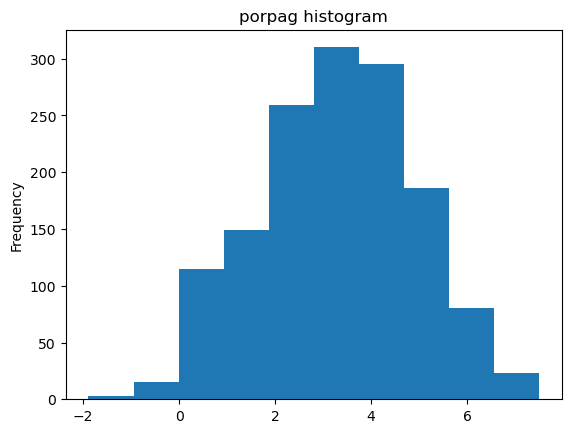

min: -1.887, max: 7.49948, mean: 3.2914118094982583, median: 3.37162, stdev: 1.6055251784789422


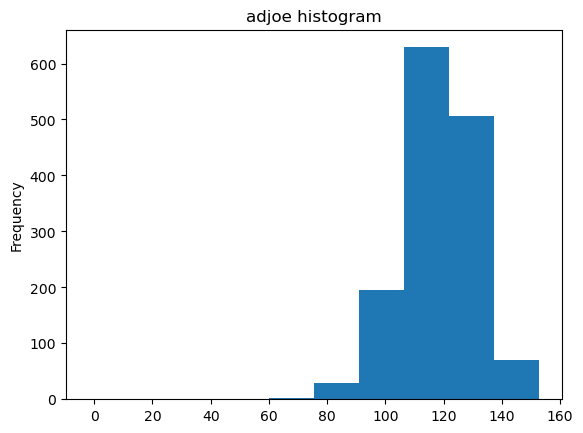

min: -1.98638, max: 152.849, mean: 118.15428064111498, median: 118.916, stdev: 12.881532936391892


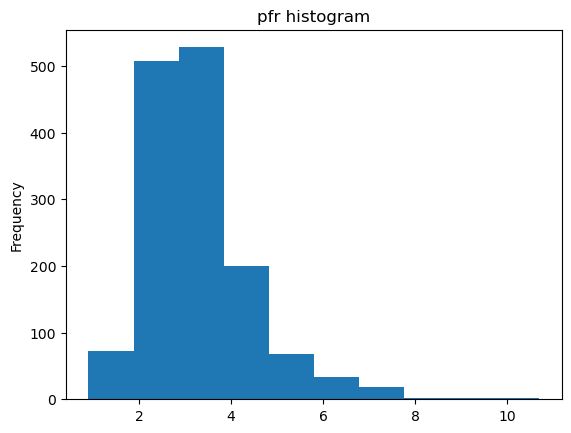

min: 0.9, max: 10.7, mean: 3.2781881533101043, median: 3.1, stdev: 1.1674416501113194


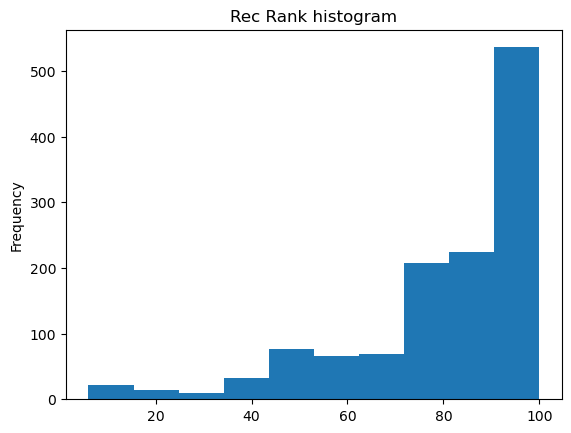

min: 6.0, max: 100.0, mean: 80.40476947535772, median: 87.2, stdev: 20.006952876225938


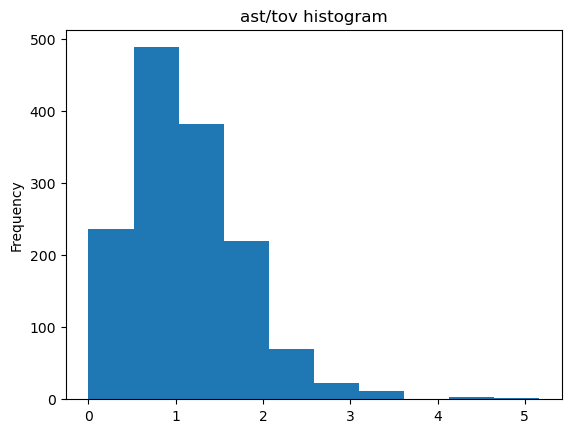

min: 0.0, max: 5.1666663, mean: 1.1281925817224545, median: 1.0283675300000001, stdev: 0.6529691704322306


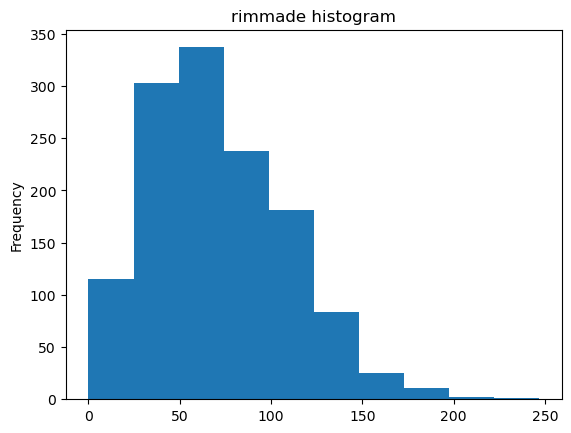

min: 0.0, max: 247.0, mean: 71.06476484194295, median: 66.0, stdev: 37.72357794725948


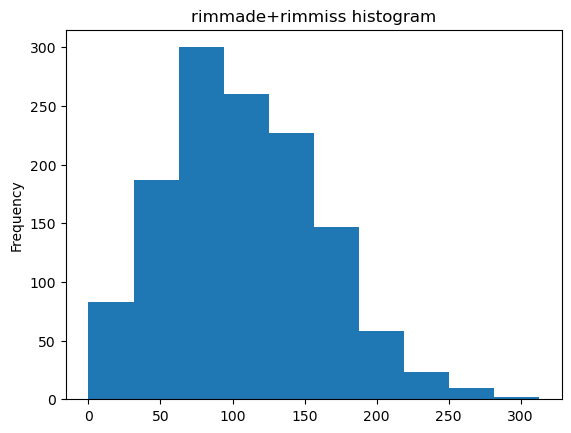

min: 0.0, max: 313.0, mean: 107.58365458750964, median: 101.0, stdev: 52.91226413209232


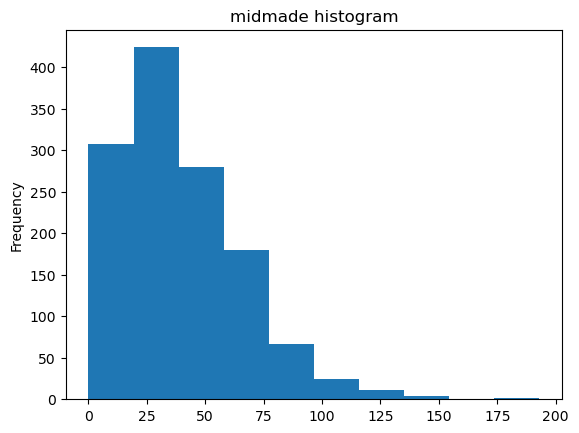

min: 0.0, max: 193.0, mean: 39.39167309175019, median: 35.0, stdev: 25.876532430159518


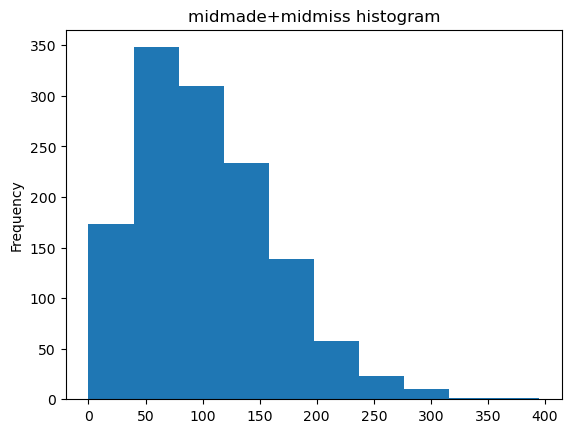

min: 0.0, max: 395.0, mean: 103.38010794140324, median: 96.0, stdev: 60.08306754182288


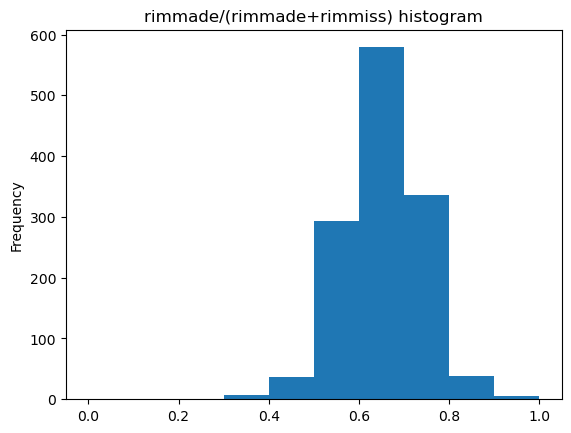

min: 0.0, max: 1.0, mean: 0.652682098765432, median: 0.6557, stdev: 0.08846648011540173


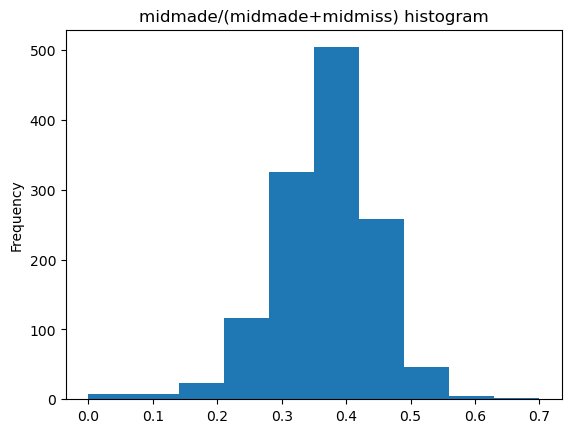

min: 0.0, max: 0.7, mean: 0.3669606949806949, median: 0.3723, stdev: 0.07929671095899152


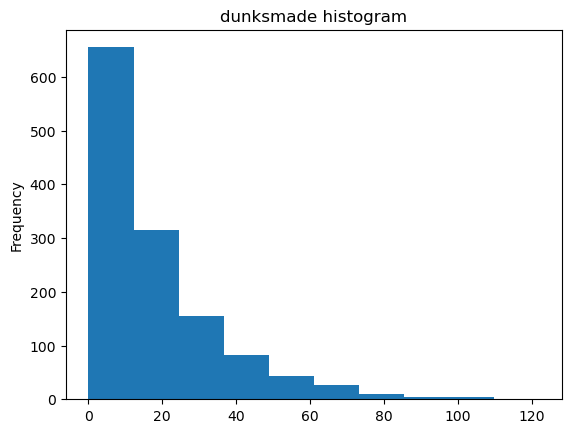

min: 0.0, max: 122.0, mean: 17.727062451811875, median: 12.0, stdev: 17.788351458585282


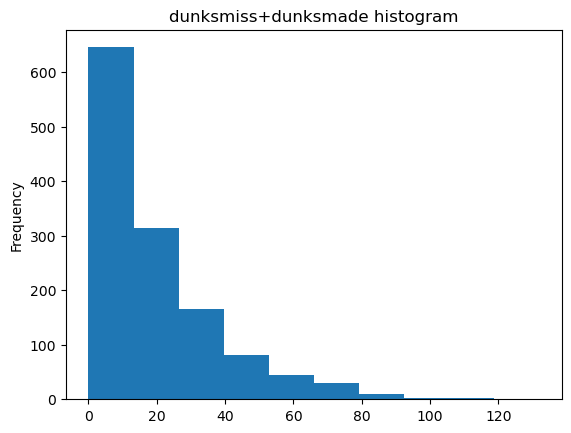

min: 0.0, max: 132.0, mean: 19.390902081727063, median: 14.0, stdev: 19.140739562283777


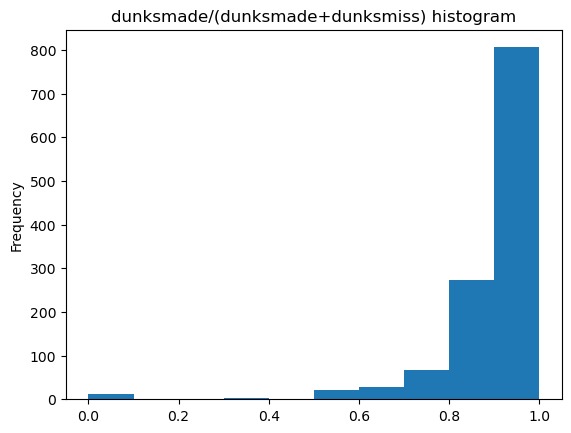

min: 0.0, max: 1.0, mean: 0.9021756177924217, median: 0.931, stdev: 0.13843513675525893


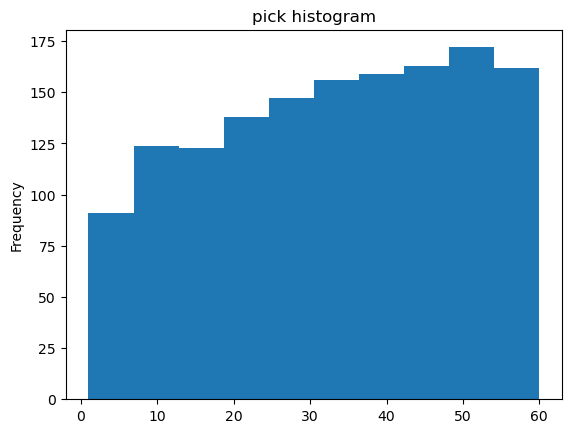

min: 1.0, max: 60.0, mean: 33.163763066202094, median: 34.0, stdev: 16.658404835376786


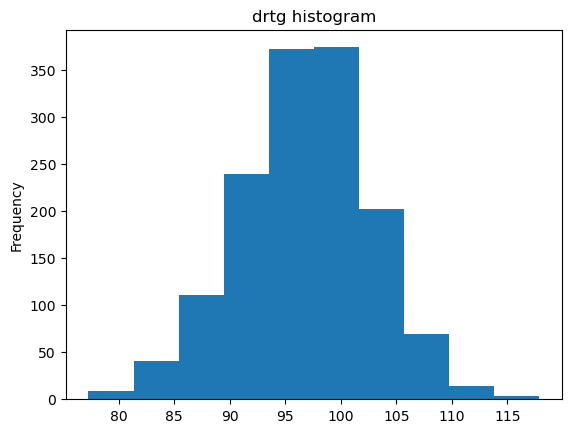

min: 77.2779, max: 117.885, mean: 96.82330536585364, median: 97.1049, stdev: 5.95008869309027


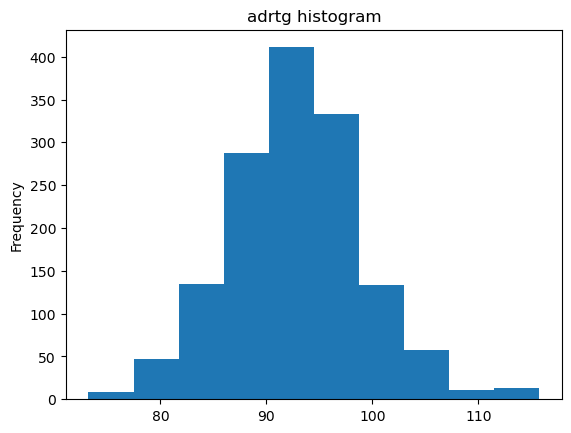

min: 73.2127, max: 115.743, mean: 92.76715986062717, median: 92.6626, stdev: 6.285847733643369


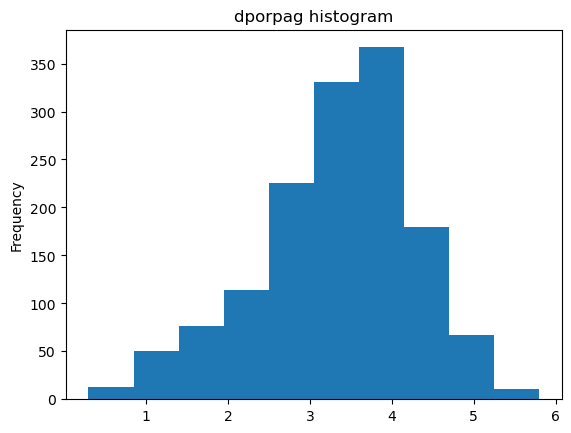

min: 0.293935, max: 5.80053, mean: 3.3362612536585368, median: 3.45722, stdev: 0.9540014172858857


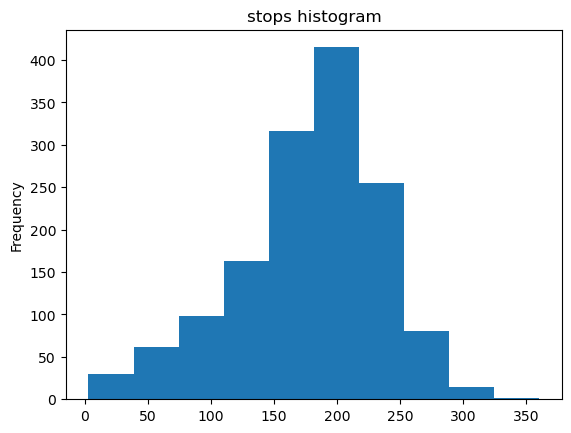

min: 3.07385, max: 360.572, mean: 177.9748604947735, median: 185.96, stdev: 57.521140299097816


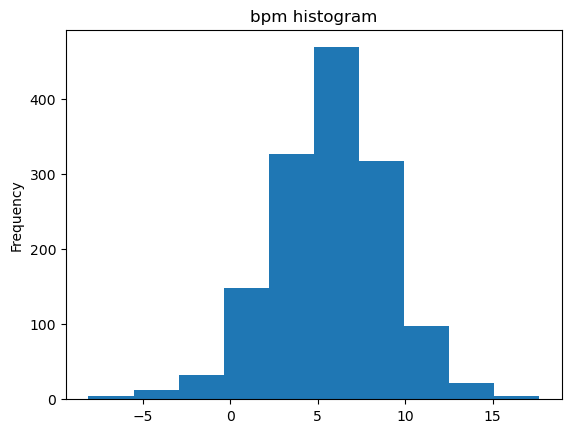

min: -8.09814, max: 17.668, mean: 5.700305786320556, median: 5.90853, stdev: 3.287325766759897


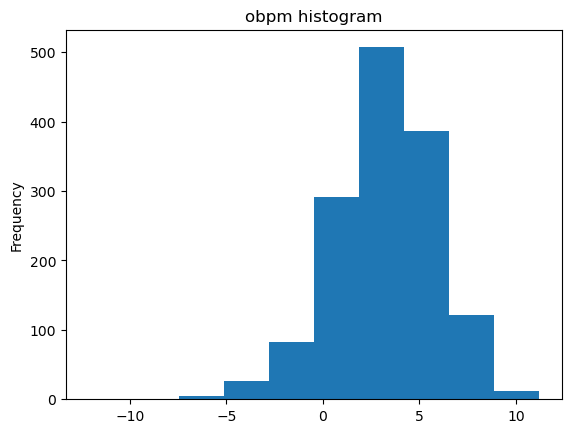

min: -12.1542, max: 11.2197, mean: 3.2231085234216033, median: 3.35271, stdev: 2.6625372044400044


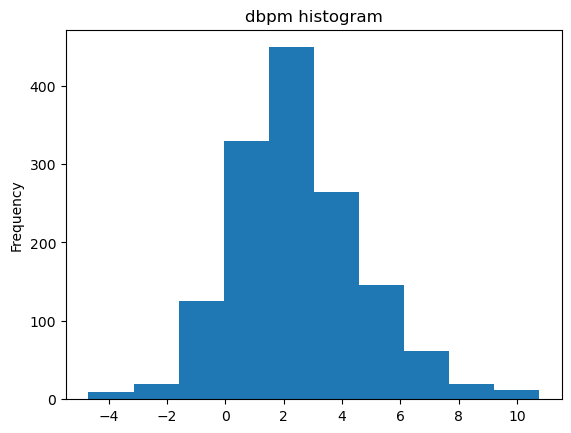

min: -4.69238, max: 10.7602, mean: 2.477197702940767, median: 2.25679, stdev: 2.2316357137195144


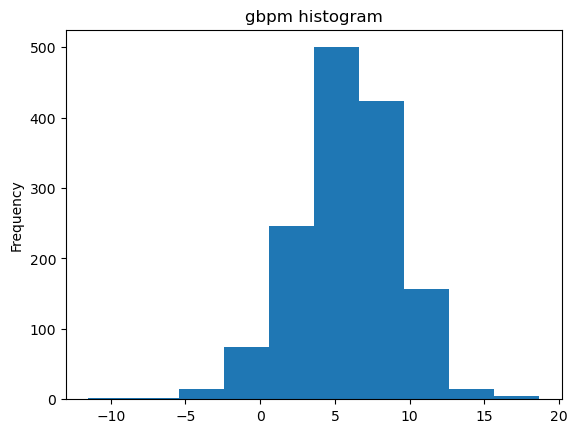

min: -11.4922, max: 18.6726, mean: 5.785684025783973, median: 5.87867, stdev: 3.39225668030674


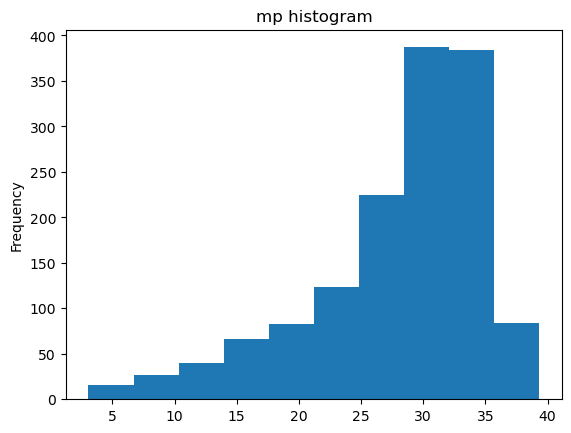

min: 3.0667, max: 39.3438, mean: 28.00425728222997, median: 30.0263, stdev: 7.026189342259817


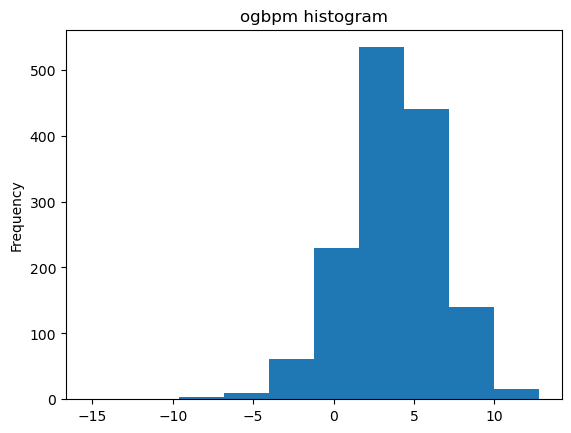

min: -15.2471, max: 12.8016, mean: 3.682969851777003, median: 3.85584, stdev: 2.911223606676927


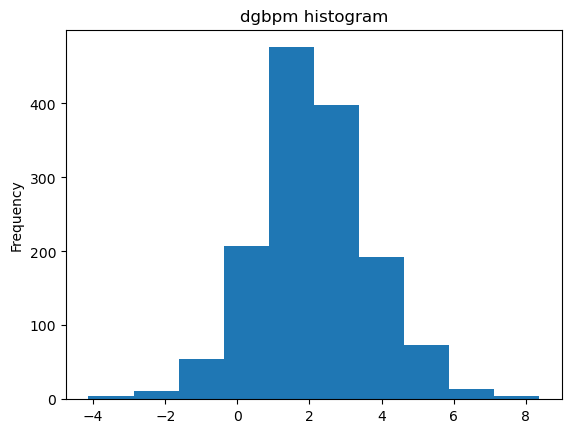

min: -4.13172, max: 8.3762, mean: 2.1027148815818815, median: 2.01473, stdev: 1.5830982454802855


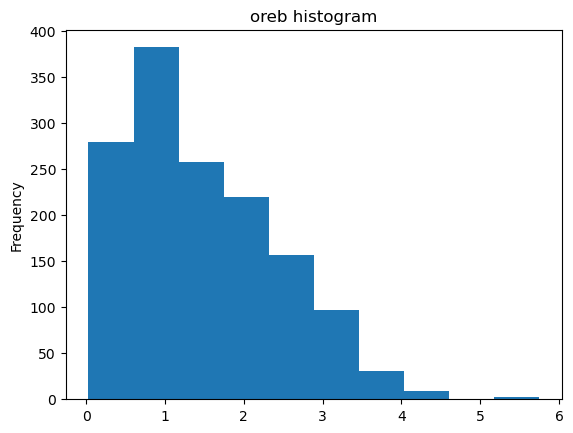

min: 0.0294, max: 5.75, mean: 1.487660836236934, median: 1.2903, stdev: 0.9389804580421661


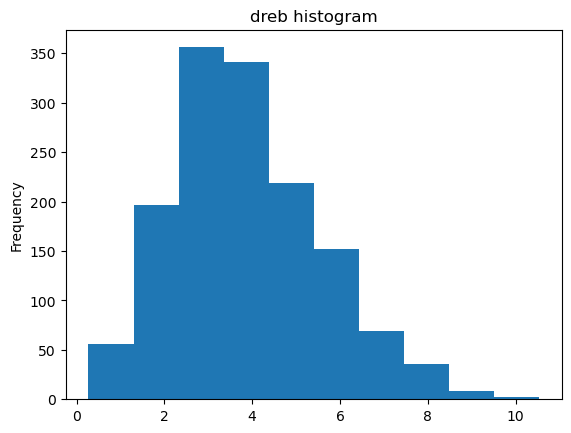

min: 0.2692, max: 10.5429, mean: 3.872030940766551, median: 3.6471, stdev: 1.6840254099168537


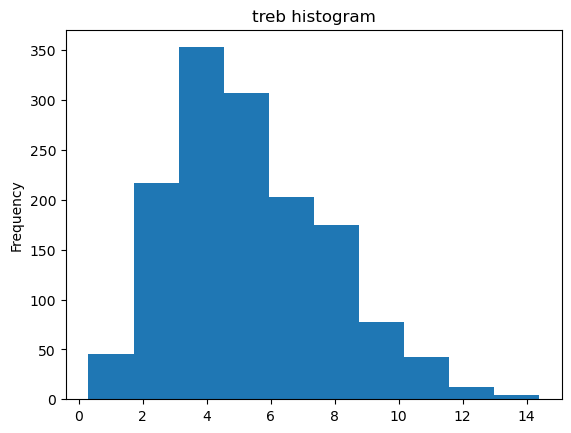

min: 0.3077, max: 14.4, mean: 5.359693101045296, median: 4.9429, stdev: 2.422036518183122


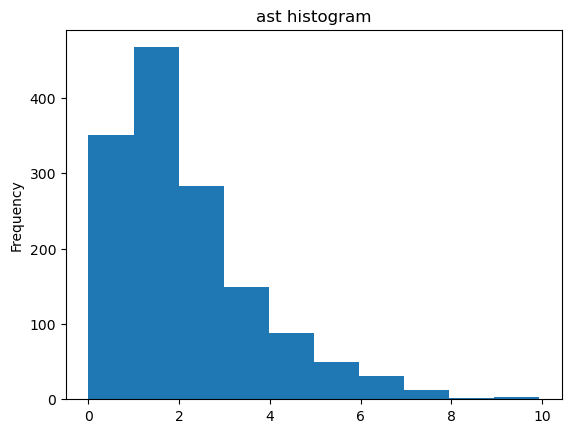

min: 0.0, max: 9.9394, mean: 2.1497101045296167, median: 1.7308, stdev: 1.577995421855569


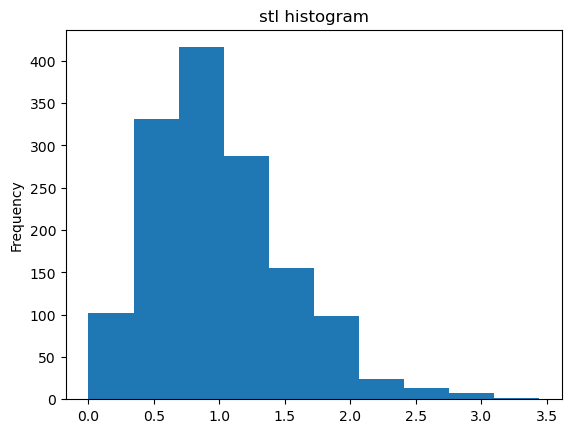

min: 0.0, max: 3.4444, mean: 0.9985699651567943, median: 0.931, stdev: 0.5139977246091809


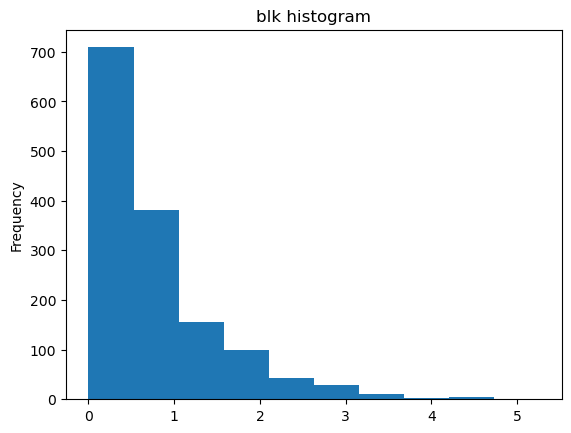

min: 0.0, max: 5.2581, mean: 0.7681149825783973, median: 0.5294, stdev: 0.7472677273490606


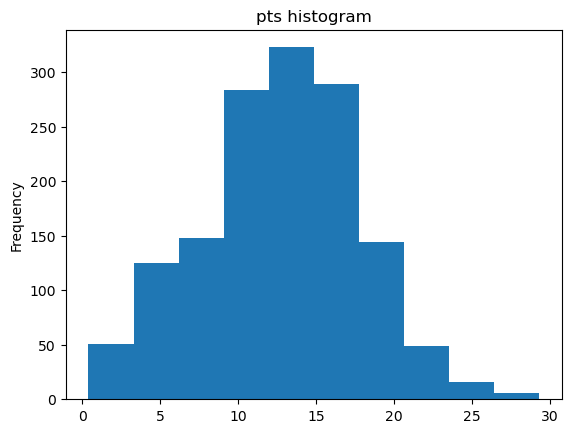

min: 0.4, max: 29.3056, mean: 12.719892264808362, median: 12.9143, stdev: 5.048082328993435


In [5]:
#Looking at and verifying histograms for each of the wanted_stats before weighting & normalization.

unwanted_stats = ["player_name","team","conf","yr","ht","num","year","pid","type","position"]
wanted_stats = [ele for ele in ncaa_df.columns if ele not in unwanted_stats]
hists_from_list(ncaa_df,wanted_stats)

In [6]:
# Random Forest Regressor

X = weighted_df.select_dtypes(include='number').drop(["year","pick"],axis=1).values
y = weighted_df["pick"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

rf = RandomForestRegressor(criterion='poisson', max_depth=6, min_samples_split=5, max_features=0.5, min_samples_leaf=7)
rf.fit(X_train, y_train)

mean_score = 0
for _ in range(10):
    mean_score += r2_score(y_test, rf.predict(X_test))
print(f"mean r2_score of random forest after 10 tests: {mean_score}")

mean r2_score of random forest after 10 tests: 2.5023889762660723
